#DeepAR Fatigue Forecasts

DeepAR important hyperparameters: num_layers, hidden_size, context_length, prediction_length, learning rate, weight_decay, dropout rate

In [ ]:
import platform
import pkg_resources

# Check the Python version
print(f"Python version: {platform.python_version()}")

# Check the installed packages
installed_packages = pkg_resources.working_set
installed_packages_list = sorted(["%s==%s" % (i.key, i.version)
   for i in installed_packages])
print("\n".join(installed_packages_list))

##Install packages and libraries

In [ ]:
!pip install numpy==1.21.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.2 which is incompatible.


In [ ]:
%%capture
%pip install tensorflow matplotlib opencv-python pandas keras gluonts scipy scikit-learn

In [ ]:
!pip install mxnet-cu117

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
from google.colab import drive # connecting to google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Import libraries and packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as pl
import gluonts
import numpy as np
import glob
import os

In [ ]:
import mxnet as mx
from mxnet import gluon
from sklearn.model_selection import train_test_split
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.transform import SimpleTransformation
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.field_names import FieldName

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Prepare the dataset for DeepAR

In [ ]:
# Read the merged dataset
data = pd.read_csv('/content/drive/MyDrive/Laboratory/project/HS/Dataset/fatigueset/a_pp/merged_fatigue.csv', index_col='timestamp', parse_dates=True, decimal = '.')

In [ ]:
data

,hr,bvp,eda,hrv,temp,TP9_alpha,AF7_alpha,AF8_alpha,TP10_alpha,TP9_beta,...,TP9_gamma,AF7_gamma,AF8_gamma,TP10_gamma,TP9_theta,AF7_theta,AF8_theta,TP10_theta,PF,MF
timestamp,,,,,,,,,,,,,,,,,,,,,
0.0,84.410000,-31.478538,0.073036,55.0,32.970000,0.467850,0.456368,0.582040,0.242963,0.563700,...,0.296789,0.214393,0.271548,0.217269,-0.027492,0.172120,0.568886,-0.019001,14.444444,14.166667
1.0,84.814251,-2.964915,0.062617,55.0,33.046063,0.467850,0.007988,0.582040,0.427981,0.574691,...,0.256293,0.199517,0.267059,0.264890,0.080415,-0.032409,0.557420,0.466136,14.449057,14.158360
2.0,85.114938,-2.301527,0.065359,55.0,33.005485,0.467850,0.066742,0.582040,0.427981,0.569917,...,0.230136,0.186814,0.262576,0.264890,0.184614,-0.000838,0.524846,0.466136,14.453668,14.150057
3.0,85.311535,4.305364,0.072797,55.0,32.941391,0.467850,0.129972,0.582040,0.427981,0.557134,...,0.216118,0.167525,0.256366,0.264890,0.259699,0.004513,0.459960,0.466136,14.458278,14.141758
4.0,85.409218,16.444607,0.075497,55.0,32.930880,0.467850,0.171005,0.580862,0.427981,0.557134,...,0.216118,0.148598,0.245496,0.264890,0.259699,0.000629,0.356142,0.466136,14.462886,14.133463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162615.0,81.244043,-38.007752,0.125563,189.0,32.450000,1.105646,0.253451,-0.107242,0.573773,0.895681,...,0.547978,-0.217799,-0.033422,0.169835,0.889673,0.591516,-0.206034,0.419402,-0.409824,12.492409
162616.0,81.967168,-41.370981,0.127134,189.0,32.452243,1.105646,0.253451,-0.028669,0.516879,0.895681,...,0.547978,-0.217799,-0.045669,0.197213,0.889673,0.591516,-0.213746,0.394710,-0.417819,12.486856
162617.0,82.667940,1.469212,0.128938,188.0,32.463182,1.105646,0.095861,0.099077,0.516879,0.895681,...,0.547978,-0.159329,-0.030365,0.236925,0.889673,0.022806,-0.151582,0.378570,-0.425815,12.481301


In [ ]:
df_input = data.reset_index(drop=True).T.reset_index()

In [ ]:
ts_code = df_input["index"].astype('category').cat.codes.values

In [ ]:
ts_code

array([24, 22, 23, 25, 26, 17,  0,  5, 12, 18,  1,  6, 13, 19,  2,  7, 14,
       20,  3,  8, 15, 21,  4,  9, 16, 11, 10], dtype=int8)

###Split into train_ds and test_ds

In [ ]:
160937*0.8

128749.6

In [ ]:
# #ratio
# train_data = df_input.iloc[:, :128749].values
# test_data = df_input.iloc[:, 128749:].values

In [ ]:
# Indices
train_end_idx = int(0.7 * 160937)  # 70% of the data for training
val_end_idx = int(0.85 * 160937)  # 15% of the data for validation

# Arrays
train_data = df_input.iloc[:, :train_end_idx].values
val_data = df_input.iloc[:, train_end_idx:val_end_idx].values
test_data = df_input.iloc[:, val_end_idx:].values

In [ ]:
train_data.shape

(27, 128749)

In [ ]:
test_data.shape

(27, 32188)

In [ ]:
freq = '1S'  #set the frequency of time series data
start_train = pd.Timestamp(0.0, freq=freq)   #set the starting point of the training
start_val = pd.Timestamp(train_end_idx, freq=freq)
start_test = pd.Timestamp(val_end_idx, freq=freq)  #set the starting point of the testing
prediction_length = 300  #set the prediction length

<ipython-input-28-d6fbd2375af1>:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_train = pd.Timestamp(0.0, freq=freq)   #set the starting point of the training
<ipython-input-28-d6fbd2375af1>:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_val = pd.Timestamp(train_end_idx, freq=freq)
<ipython-input-28-d6fbd2375af1>:4: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_test = pd.Timestamp(val_end_idx, freq=freq)  #set the starting point of the testing


In [ ]:
# Create a ListDataset for each target variable
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip([train_data[25, 1:], train_data[26, 1:]], ts_code[0:27].reshape(-1, 1))
], freq=freq)

In [ ]:
# Create a ListDataset for each target variable
val_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_val,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip([train_data[25, 1:], train_data[26, 1:]], ts_code[0:27].reshape(-1, 1))
], freq=freq)

In [ ]:
# Create a ListDataset for each target variable
test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip([test_data[25, 1:], test_data[26, 1:]], ts_code[0:27].reshape(-1, 1))
], freq=freq)

In [ ]:
# Create a DeepAR estimator
estimator = DeepAREstimator(freq=freq,
                                                  context_length=prediction_length,
                                                  prediction_length = prediction_length,
                                                  use_feat_static_cat=True,
                                                  cardinality = [1],
                                                  num_layers = 5,
                                                  num_cells = 60,
                                                  cell_type = 'lstm',
                                                  batch_size =32,
                                                  trainer=Trainer(epochs=15))

##Train the DeepAR model

In [ ]:
# Train the DeepAR model
predictor = estimator.train(training_data=train_ds, verbose=1)

100%|██████████| 50/50 [04:05<00:00,  4.91s/it, epoch=15/15, avg_epoch_loss=0.684]


In [ ]:
from pathlib import Path

In [ ]:
# Define the directory
dir_path = '/content/drive/MyDrive/Laboratory/project/HS/Code/Ensemble Model/DeepAR/deepar_model'

# Create the directory if it does not exist
os.makedirs(dir_path, exist_ok=True)

# Save the model
predictor.serialize(Path(dir_path))

##DeepAR Forecasts

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
#Make predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor = predictor,
    num_samples=1000,
)

In [ ]:
print("Obtaining time series conditioning values ... ")
tss = list(tqdm(ts_it, total = len(test_data)))   #obtaining the list of time series conditioning values
print("Obtaining time series predictions ...")
forecast = list(tqdm(forecast_it, total = len(test_data)))  #obtaining the time series predictions

Obtaining time series conditioning values ... 


  0%|          | 0/27 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/27 [00:00<?, ?it/s]

##Plot Forecasts

In [ ]:
##Plot prediction results

def plot_prob_forecasts(ts_entry, forecast_entry):   #time series entry and forecast entry
    plot_length = prediction_length
    prediction_intervals = (90.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

def plot_prob_forecasts(ts_entry, forecast_entry, prediction_intervals, plot_length):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ts_entry[-plot_length:].plot(ax=ax)

    # Plotting the forecast quantiles
    for quantile in prediction_intervals:
        ax.fill_between(
            forecast_entry.index[-plot_length:],
            forecast_entry.quantile(quantile)[-plot_length:],
            forecast_entry.quantile(1 - quantile)[-plot_length:],
            color='g',
            alpha=0.2
        )

    plt.grid(which="both")
    plt.legend(["Observation", "Forecast"], loc="upper left")

prediction_intervals = [0.8, 0.95]  # Define the desired prediction intervals
plot_length = 300  # Define the number of time steps to plot

  0%|          | 0/2 [00:00<?, ?it/s]

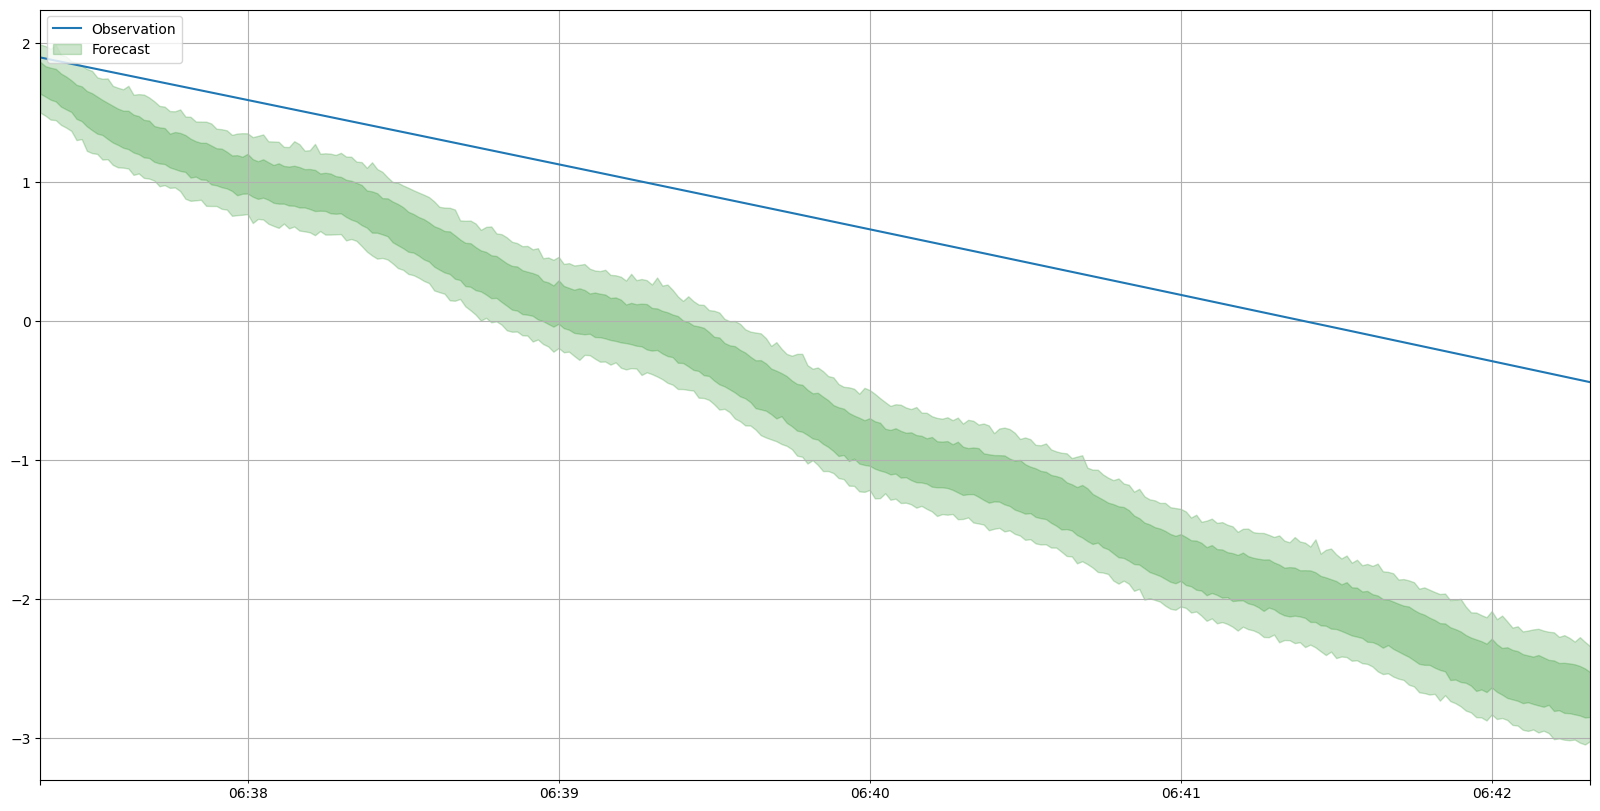

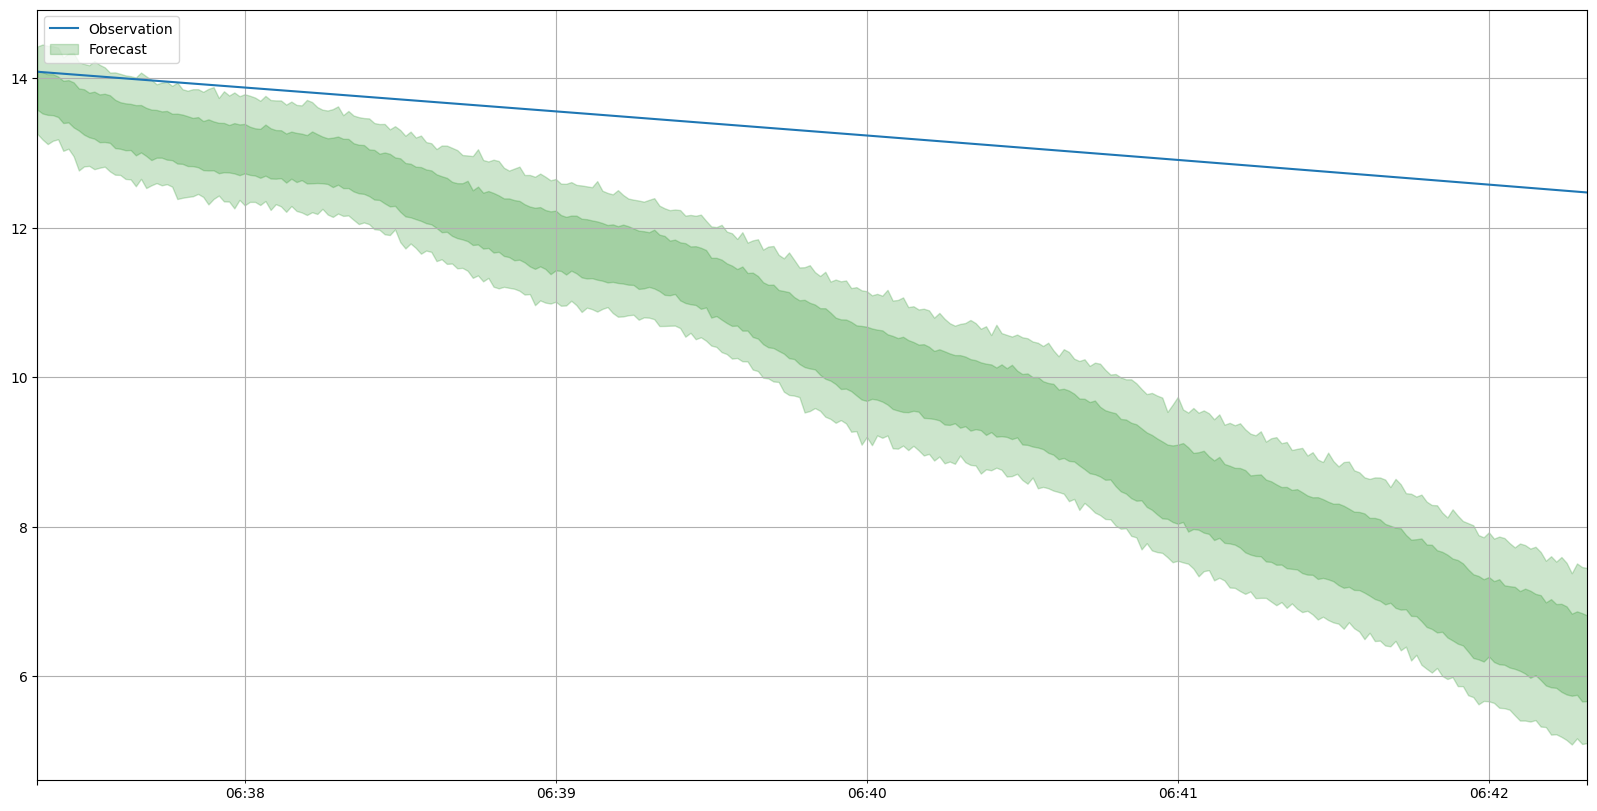

In [ ]:
for i in tqdm(range(len(forecast))):
    ts_entry = tss[i]
    forecast_entry = forecast[i]
    plot_prob_forecasts(ts_entry, forecast_entry, prediction_intervals, plot_length)

In [ ]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 1000
Dimension of samples: (1000, 300)
Start date of the forecast window: 1970-01-01 06:37:20
Frequency of the time series: <Second>


In [ ]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

##Performance Evaluation

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecast), num_series=len(test_data[25:]))

Running evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


In [ ]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,1970-01-01 06:37:20,2.138128,397.258301,245.492218,0.818307,6.461931,0.204922,10.645719,1.459702,1.618211,5.745601,94.491150,0.0,397.258356,0.0,579.772085,0.013333
1,None,1970-01-01 06:37:20,11.408730,865.993896,3985.611816,13.285373,11.203709,0.257651,0.222213,0.264806,0.217280,6.632610,213.486491,0.0,865.993900,0.0,1191.298900,0.026667


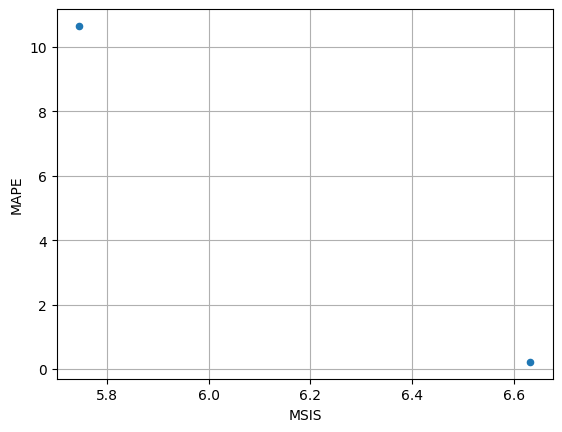

In [ ]:
item_metrics.plot(x="MSIS", y="MAPE", kind="scatter")
plt.grid(which="both")
plt.show()

##Hyperparameter Tuning

In [ ]:
%%capture
%pip install optuna

In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Here we optimize the hyperparameters of DeepAR
    trainer = Trainer(
        ctx=mx.gpu(0),
        epochs=trial.suggest_int("epochs", 15, 25),
        learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
    )

    estimator = DeepAREstimator(
        trainer=trainer,
        context_length=trial.suggest_int("context_length", 800, 5000),
        num_layers=trial.suggest_int("num_layers", 2, 4),
        num_cells=trial.suggest_int("num_cells", 40, 100),
        batch_size = trial.suggest_int("batch_size",32,128),
        freq='S',
        prediction_length=trial.suggest_int("prediction_length",60, 300),
        dropout_rate=trial.suggest_float("dropout_rate",0.1,0.5),
    )

    # We fit the model and calculate the accuracy on test set
    predictor = estimator.train(training_data=train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,
        predictor=predictor,
        num_samples=100
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

    print(agg_metrics)

    return agg_metrics["RMSE"]  # objective is to minimize RMSE

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

trial = study.best_trial

print("Best trial:")
print("  Value: ", trial.value)

print("Best parameters: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-08-05 15:53:08,199] A new study created in memory with name: no-name-6c522e4d-f7d2-49f4-80f6-d7dfb9c0c3a2
100%|██████████| 50/50 [11:23<00:00, 13.68s/it, epoch=23/23, avg_epoch_loss=0.336]
